## Transformers - Wind Power - PE La Castellana

In [1]:
from neuralforecast import NeuralForecast
#from itransformer import iTransformer
from neuralforecast.models import NHITS, PatchTST, iTransformer, TSMixer
from utilsforecast.losses import mae, mse
from utilsforecast.evaluation import evaluate

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#path = 'https://raw.githubusercontent.com/guilledesimone/MMA/main/df_clean_ba.csv'
path = 'D:\\Documents\\MMA\\1.0 Tesis\\Datos\\df_clean_ba2804.csv'

data_types = {                
    'AerosDisp': float
    ,'VelViento': float
    ,'DirViento': float
    ,'TempAmb': float
    ,'HumedadRel': float
    ,'PresionAtm': float
    ,'EnergiaSMEC': float
    ,'wspd_ms': float
    ,'wdir': float
    ,'temp': float
    ,'pres': float
    ,'wspd_rlm': float
    ,'wspd_lstm': float
}


df = pd.read_csv(path, dtype=data_types, decimal=',', parse_dates=['FechaHora'], 
                 date_format='%Y-%m-%d %H:%M:%S', delimiter=';', header=0)

#### Separamos datos historicos y de Forecast

In [3]:
# Create df_forecast by filtering the subset where EnergiaSMEC is null and selecting specified variables
df_forecast_exog = df[df['EnergiaSMEC'].isnull()][['FechaHora','AerosDisp','wspd_lstm','wdir','temp','pres','rhum']]

# set index 'FechaHora'
#df_forecast_exog.set_index('FechaHora', inplace=True)

In [4]:
#El forecast de AerosDisp lo estimo en base al valor medio de las últimas 12 horas

# Filter the subset where AerosDisp is not null
filtered_df = df.dropna(subset=['AerosDisp'])

# Calculate the mean of AerosDisp foAerosDispr
mean_aeros_disp = filtered_df.tail(12)['AerosDisp'].mean()

df_forecast_exog['AerosDisp'] = mean_aeros_disp.round(2)
df_forecast_exog.head()

,FechaHora,AerosDisp,wspd_lstm,wdir,temp,pres,rhum
46644,2024-04-28 09:00:00,29.69,9.57,308.0,9.2,1010.3,59.0
46645,2024-04-28 10:00:00,29.69,9.43,301.0,11.1,1010.1,53.0
46646,2024-04-28 11:00:00,29.69,9.30,294.0,13.0,1009.8,48.0
46647,2024-04-28 12:00:00,29.69,9.10,287.0,14.5,1009.4,43.0
46648,2024-04-28 13:00:00,29.69,8.92,288.0,16.2,1008.6,38.0


Se limpian valores historicos

In [5]:
df=df.dropna(subset=['EnergiaSMEC', 'wspd_lstm'])

In [6]:
df['FechaHora'] = pd.to_datetime(df['FechaHora'])
df.set_index('FechaHora', inplace=True)

# Define horizon and frequency
horizon = 6  # Assuming we want to forecast one step ahead
freq = 'H'

# Add the new column 'unique_id' with values [1.0]*len(df)
df['unique_id'] = [1.0] * len(df)

# Define input and target variables
X = df[['AerosDisp', 'wspd_lstm', 'wdir', 'temp', 'pres', 'rhum']].values
y = df['EnergiaSMEC'].values

In [7]:
# Define the iTransformer model
models = [
    iTransformer(h=horizon, input_size=3*horizon + X.shape[1], n_series=1, max_steps=1000, early_stop_patience_steps=3),
    TSMixer(h=horizon, input_size=3*horizon + X.shape[1], n_series=1, max_steps=1000, early_stop_patience_steps=3),
    NHITS(h=horizon, input_size=3*horizon + X.shape[1], max_steps=1000, early_stop_patience_steps=3),
    PatchTST(h=horizon, input_size=3*horizon + X.shape[1], max_steps=1000, early_stop_patience_steps=3)
]

C:\Users\gdesimone\AppData\Local\anaconda3\envs\tesis-python-3.11\Lib\site-packages\pytorch_lightning\utilities\parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1


In [8]:
# Initialize NeuralForecast
nf = NeuralForecast(models=models, freq=freq)

In [9]:
# Define validation and test sizes
val_size = int(len(df) * 0.1)
test_size = int(len(df) * 0.1)

# Create a DataFrame with 'ds', 'y', and 'exog' columns
df_input = pd.DataFrame({'ds': df.index, 'y': y})
for i, col in enumerate(['AerosDisp', 'wspd_lstm', 'wdir', 'temp', 'pres', 'rhum']):
    df_input[col] = X[:, i]

df_input['unique_id'] = [1.0] * len(df)

# Perform cross-validation
#nf_preds = nf.cross_validation(df=pd.DataFrame({'ds': df.index, 'y': y,'unique_id': df['unique_id'], 'exog': list(X) }), val_size=val_size, test_size=test_size, n_windows=None)
nf_preds = nf.cross_validation(df=df_input, val_size=val_size, test_size=test_size, n_windows=None)



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params
---------------------------------------------------------
0 | loss          | MAE                    | 0     
1 | padder        | ConstantPad1d          | 0     
2 | scaler        | TemporalNorm           | 0     
3 | enc_embedding | DataEmbedding_inverted | 12.8 K
4 | encoder       | TransEncoder           | 6.3 M 
5 | projector     | Linear                 | 3.1 K 
---------------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.287    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|                                                              | 0/1 [00:00<?, ?it/s]

C:\Users\gdesimone\AppData\Local\anaconda3\envs\tesis-python-3.11\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


C:\Users\gdesimone\AppData\Local\anaconda3\envs\tesis-python-3.11\Lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
C:\Users\gdesimone\AppData\Local\anaconda3\envs\tesis-python-3.11\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
C:\Users\gdesimone\AppData\Local\anaconda3\envs\tesis-python-3.11\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|█████████████████| 1/1 [00:00<00:00, 11.17it/s, v_num=35, train_loss_step=17.40, train_loss_epoch=25.20]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]
Epoch 199: 100%|█| 1/1 [00:00<00:00,  9.77it/s, v_num=35, train_loss_step=22.10, train_loss_epoch=24.30, valid_loss=20.
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]
Epoch 299: 100%|█| 1/1 [00:00<00:00, 10.86it/s, v_num=35, train_loss_step=17.70, train_loss_epoch=19.40, valid_loss=21.
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|█| 1/1 [00:01<00:00,  0.93it/s, v_num=35, train_loss_step=20.40, train_loss_epoch=20.40, valid_loss=18.

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


C:\Users\gdesimone\AppData\Local\anaconda3\envs\tesis-python-3.11\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                     | Params
-----------------------------------------------------------
0 | loss          | MAE                      | 0     
1 | padder        | ConstantPad1d            | 0     
2 | scaler        | TemporalNorm             | 0     
3 | norm          | ReversibleInstanceNorm1d | 2     
4 | mixing_layers | Sequential               | 1.8 K 
5 | out           | Linear                   | 150   
-----------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)



Epoch 99: 100%|█████████████████| 1/1 [00:00<00:00, 22.22it/s, v_num=37, train_loss_step=26.30, train_loss_epoch=35.60]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.71it/s]
Epoch 199: 100%|█| 1/1 [00:00<00:00, 21.65it/s, v_num=37, train_loss_step=28.00, train_loss_epoch=25.00, valid_loss=26.
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.09it/s]
Epoch 299: 100%|█| 1/1 [00:00<00:00, 19.87it/s, v_num=37, train_loss_step=19.30, train_loss_epoch=21.50, valid_loss=23.
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|█| 1/1 [00:00<00:00,  4.47it/s, v_num=37, train_loss_step=20.70, train_loss_epoch=20.70, valid_loss=17.


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.55it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.728     Total estimated model params size (MB)


Epoch 99: 100%|█████████████████| 1/1 [00:00<00:00,  6.57it/s, v_num=39, train_loss_step=17.00, train_loss_epoch=17.30]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.99it/s]
Epoch 199: 100%|█| 1/1 [00:00<00:00,  5.95it/s, v_num=39, train_loss_step=17.30, train_loss_epoch=17.10, valid_loss=16.
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.16it/s]
Epoch 299: 100%|█| 1/1 [00:00<00:00,  5.90it/s, v_num=39, train_loss_step=16.70, train_loss_epoch=17.20, valid_loss=16.
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.10it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | loss         | MAE               | 0     
1 | padder_train | ConstantPad1d     | 0     
2 | scaler       | TemporalNorm      | 0     
3 | model        | PatchTST_backbone | 402 K 
---------------------------------------------------
402 K     Trainable params
3         Non-trainable params
402 K     Total params
1.609     Total estimated model params size (MB)


Epoch 99: 100%|█████████████████| 1/1 [00:00<00:00,  3.78it/s, v_num=41, train_loss_step=18.00, train_loss_epoch=18.10]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]
Epoch 199: 100%|█| 1/1 [00:00<00:00,  3.96it/s, v_num=41, train_loss_step=18.10, train_loss_epoch=17.80, valid_loss=16.
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]
Epoch 299: 100%|█| 1/1 [00:00<00:00,  3.81it/s, v_num=41, train_loss_step=17.60, train_loss_epoch=18.10, valid_loss=16.
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|█| 1/1 [00:00<00:00,  1.40it/s, v_num=41, train_loss_step=17.10, train_loss_epoch=17.10, valid_loss=16.

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


C:\Users\gdesimone\AppData\Local\anaconda3\envs\tesis-python-3.11\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


### Performance Evaluation

In [10]:
nf_preds.reset_index(inplace=True)

In [11]:
nf_preds.head()

,unique_id,ds,cutoff,iTransformer,TSMixer,NHITS,PatchTST,y
0,1.0,2023-10-17 02:00:00,2023-10-17 01:00:00,25.863441,41.130379,29.617081,29.538826,27.56
1,1.0,2023-10-17 03:00:00,2023-10-17 01:00:00,28.540844,41.016663,26.137415,28.424667,20.06
2,1.0,2023-10-17 04:00:00,2023-10-17 01:00:00,28.592606,41.989445,22.073318,25.882812,10.75
3,1.0,2023-10-17 05:00:00,2023-10-17 01:00:00,28.784286,40.989998,20.782227,25.410124,0.66
4,1.0,2023-10-17 06:00:00,2023-10-17 01:00:00,28.891287,40.345501,21.992765,25.861160,0.00


In [12]:
df_evaluation = evaluate(df=nf_preds, metrics=[mae, mse], models=['iTransformer', 'TSMixer', 'NHITS', 'PatchTST'])

In [13]:
df_evaluation = df_evaluation.drop(['unique_id'], axis=1)

In [14]:
df_evaluation.head()

,metric,iTransformer,TSMixer,NHITS,PatchTST
0,mae,17.862570,17.720886,16.314796,16.434749
1,mse,578.579267,589.095035,533.563581,548.934619


### Plot the metrics

NameError: name 'model_names' is not defined

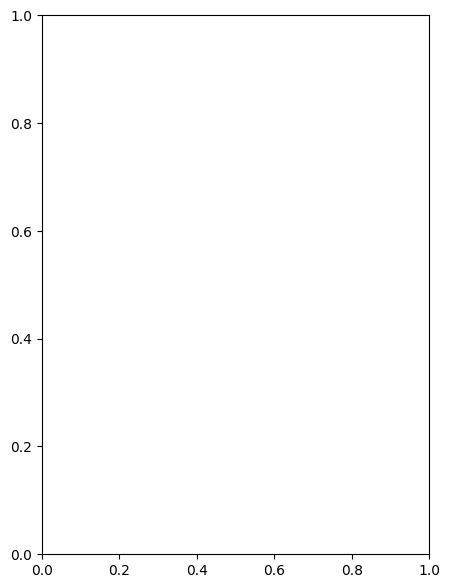

In [16]:
full_df = df_evaluation.copy()
fig, axs = plt.subplots(1, 1, figsize=(5, 7)) 
bar_width = 0.35  

df_subset = full_df[full_df['metric'] == 'mae']
mae_vals = df_subset[model_names].values.flatten()
df_subset = full_df[full_df['metric'] == 'mse']
mse_vals = df_subset[model_names].values.flatten()
    
indices = np.arange(len(model_names))
    
bars_mae = axs.bar(indices - bar_width / 2, mae_vals, bar_width, color='skyblue', label='MAE')
bars_mse = axs.bar(indices + bar_width / 2, mse_vals, bar_width, color='orange', label='MSE')
    
for bars in [bars_mae, bars_mse]:
     for bar in bars:
         height = bar.get_height()
         axs.annotate(f'{height:.2f}', 
                      xy=(bar.get_x() + bar.get_width() / 2, height),
                      xytext=(0, 3),
                      textcoords="offset points",
                      ha='center', va='bottom')
    
axs.set_xticks(indices)
axs.set_xticklabels(model_names, rotation=45)
axs.set_title('WindPower Prediction Error')  # Set the title accordingly
axs.legend(loc='best')

plt.tight_layout() 
plt.show()


El modelo NHITS es el que tiene mejor performance en MAE y MSE

#### Prediccion de valores futuros de EnergiaSMEC utilizando variables exogenas

In [ ]:
# Rename the column "FechaHora" to "ds" and reset the index
df_forecast_exog.rename(columns={'FechaHora': 'ds'}, inplace=True)
df_forecast_exog.reset_index(drop=True, inplace=True)

df_forecast_exog.head()

In [62]:
# Specify the index of the model you want to use for prediction
model_index = 2  # Index of the model you want to use, e.g., 0 for the first model

# Get the specific model from the NeuralForecast object
model = nf.models[model_index]  

# Generate forecasts for the target variable 'y' using the specific model
target_forecast = model.predict(df=pd.DataFrame({'ds': df_forecast_exog['ds']}), steps=len(df_forecast_exog))

# Update the 'y' column in df_forecast_exog with the forecasted values
df_forecast_exog['y'] = target_forecast


TypeError: BaseWindows.predict() missing 1 required positional argument: 'dataset'

In [51]:
#Prepare input data with forecasted exogenous variables

#forecast_input = pd.DataFrame({'ds': future_dates})
#for i, col in enumerate(['AerosDisp', 'wspd_lstm', 'wdir', 'temp', 'pres', 'rhum']):
#    forecast_input[col] = forecasted_exog[:, i]

# Use the specified model for prediction
forecast_preds = nf.predict(df=df_forecast_exog, model_index=model_index)

# Print or use forecast_preds for further analysis
print(forecast_preds)

ValueError: Found missing values in ['y'].

VER: https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/LongHorizon_with_Transformers.ipynb#scrollTo=W9Ppep629Hcb